<a href="https://colab.research.google.com/github/chuiyunjun/aps490/blob/chi/model_6_Valve_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
#!pip install torch==1.10.0
#!pip install kats
#!pip install gdown
import torch.nn as nn
import torch
from tqdm.notebook import tqdm as tqdm
import random
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
# !pip install pytorch-forecasting
# from pytorch_forecasting.metrics import MAPE, MAE
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ML

In [ ]:
file_name = r'/content/drive/MyDrive/APS490/Datasets/VAV-1704-Valve-analysis.csv'
df = pd.read_csv(file_name)

In [ ]:
df_all = pd.read_csv('/content/drive/MyDrive/APS490/Datasets/merge_CPPIB_17th.csv')
df_all.columns


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,14,16,30,44,58,72,86,100,114,128,142,156,170,184,198,212,226,240,254,268,282,296,310,324,338,352,366,380,394,408,422,436,450,464,478,492,506,520,534,548,562,576,590,604) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['DateTime',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room.Occupancy',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room.Unit State',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Direct Expansion Cooling.Condenser Water Temperature',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Direct Expansion Cooling.Cooling Capacity',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Direct Expansion Cooling.Enable',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Discharge Air.Static Pressure',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Discharge Air.Static Pressure Setpoint',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Discharge Air.Temperature',
       'Modern Niagara > CPPIB > 17th Flr > CU-17-01 _ 1723 Mechanical Room > Discharge Air.Temperatur

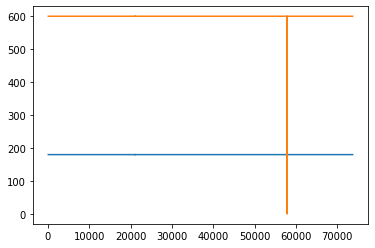

In [ ]:
plt.plot(df_all[['Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Cooling Minimum Setpoint']])
plt.plot(df_all[['Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Cooling Maximum Setpoint']])

In [ ]:
date = 'DateTime_x'
input1 = 'Temp (°C)'
input2 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Fin Tube Radiation.Valve Position'
input3 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Zone Air.Temperature'
input4 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow'
input5 = 'Modern Niagara > CPPIB > 17th Flr > VAV-1704 > Primary Air.Air Flow Setpoint'

input_list = [input1, input2, input3, input4,input5]
# dataset file name
df_input = df[input_list]
df_input = df_input.dropna()

In [ ]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import csv 
import shutil
from numpy.lib.index_tricks import diag_indices_from

In [ ]:
def sliding_windows(data, seq_length, pred_length, sc):
    x = []
    y = []
    samples = []
    for i in range(len(data)-seq_length-pred_length):
        sample = data[i:(i+seq_length+pred_length)]
        samples.append(sample)
    random.shuffle(samples)
    x = np.array(samples)[:,:seq_length,:]
    y = np.array(samples)[:,seq_length:,:]
    y = y[:,:,1]
    return x, y

def train_test_split(x, y, param):
  train_size = param['train_size']
  validation_size = param['validation_size']
  test_size = param['test_size']


  dataX = torch.Tensor(np.array(x)).to('cuda')
  dataY = torch.Tensor(np.array(y)).to('cuda')

  trainX = torch.Tensor(np.array(x[0:train_size])).to('cuda')
  trainY = torch.Tensor(np.array(y[0:train_size])).to('cuda')

  validationX = torch.Tensor(np.array(x[train_size: train_size+validation_size])).to('cuda')
  validationY = torch.Tensor(np.array(y[train_size: train_size+validation_size])).to('cuda')

  # testY doesn't contain 0
  testX = []
  testY = []
  index = train_size+validation_size
  i = 0
  val_count = 0
  inval_count = 0
  while i < train_size and index < len(y):
    if np.all(y[index]):
      testX.append(x[index])
      testY.append(y[index])
      i += 1
      val_count += 1
    else:
      inval_count += 1
    index += 1
  print('val:', val_count, 'inval_count', inval_count)
  testX = torch.Tensor(np.array(testX)).to('cuda')
  testY = torch.Tensor(np.array(testY)).to('cuda')
  # testX = torch.Tensor(np.array(x[train_size+validation_size:train_size+validation_size+train_size])).to('cuda')
  # testY = torch.Tensor(np.array(y[train_size+validation_size:train_size+validation_size+train_size])).to('cuda')
  return dataX, dataY, trainX, trainY, validationX, validationY, testX, testY

def batch_split(x, y, param):
  l = len(x)
  if 'batch_size' in param:
    batch_size = param['batch_size']
    batch_num = l // param['batch_size'] if l // param['batch_size'] == 0 else l // param['batch_size'] + 1
  elif 'batch_num' in param:
    batch_num = param['batch_num']
    batch_size = l // param['batch_num'] if l // param['batch_num'] == 0 else l // param['batch_num'] + 1
  
  x_list, y_list = [], []
  for i in range(batch_num):
    if (i+1) * batch_size > l:
      x_list.append(x[i * batch_size: ])
      y_list.append(y[i * batch_size: ])
    else: 
      x_list.append(x[i * batch_size: (i+1) * batch_size])
      y_list.append(y[i * batch_size: (i+1) * batch_size])
  return x_list, y_list, batch_num

def train_and_evaluate(param, validationX, validationY, trainX, trainY, model):
  train_loss_list = torch.tensor([]).to('cuda')
  validation_loss_list = torch.tensor([]).to('cuda')
  
  trainX, trainY, num_batches = batch_split(trainX, trainY, param)
  validationX, validationY, num_batches = batch_split(validationX, validationY, param)

  optimizer = param["optimizer"]
  if param['criterion'] == 'mse':
    criterion = torch.nn.MSELoss()
  elif param['criterion'] == 'mae':
    criterion = torch.nn.L1Loss()
  elif param['criterion'].startswith('huber'):
    delta = float(param['criterion'].split('_')[1])
    criterion = torch.nn.HuberLoss(delta=delta)
  elif param['criterion'] == 'nll':
    criterion = torch.nn.NLLLoss()
  else:
    print('Invalid criterion name: {}'.format(param['criterion']))

  # Train the model
  for epoch in tqdm(range(param['num_epochs'])):
      curr_batch_train_loss_list = torch.tensor([]).to('cuda')
      curr_batch_validation_loss_list = torch.tensor([]).to('cuda')
      for b in range(num_batches):
        outputs = model(trainX[b])
        optimizer.zero_grad()

        # obtain the loss function
        train_loss = criterion(outputs, trainY[b])

        curr_batch_train_loss_list = torch.cat((curr_batch_train_loss_list ,torch.tensor([train_loss.item()]).to('cuda')))

        train_loss.backward()
        
        optimizer.step()

        with torch.no_grad():
          pred_validationY = model(validationX[b])
          validation_loss = criterion(pred_validationY, validationY[b])
          curr_batch_validation_loss_list = torch.cat((curr_batch_validation_loss_list ,torch.tensor([validation_loss.item()]).to('cuda')))

      train_loss_list = torch.cat((train_loss_list ,torch.tensor([curr_batch_train_loss_list.mean().item()]).to('cuda')))
      validation_loss_list = torch.cat((validation_loss_list ,torch.tensor([curr_batch_validation_loss_list.mean().item()]).to('cuda')))

      if (epoch + 1) % 50 == 0:
        print("Epoch: %d, train_loss: %1.5f, val_loss: %1.5f" % (epoch, curr_batch_train_loss_list.mean().item(), curr_batch_validation_loss_list.mean().item()))
  return model, train_loss_list, validation_loss_list

def execute_and_save(param, model_name,  trainX, trainY, validationX, validationY, testX, testY):


  if param['criterion'] == 'mse':
    criterion = torch.nn.MSELoss()
  elif param['criterion'] == 'mae':
    criterion = torch.nn.L1Loss()
  elif param['criterion'].startswith('huber'):
    delta = float(param['criterion'].split('_')[1])
    criterion = torch.nn.HuberLoss(delta=delta)
  elif param['criterion'] == 'nll':
    criterion = torch.nn.NLLLoss()
  else:
    print('Invalid criterion name: {}'.format(param['criterion']))

  if model_name == 'lstm':
    model = LSTM(param['num_classes'], param['input_size'], param['hidden_size'], param['num_layers'])
  elif model_name == 'gru':
    model = GRUNet(param['num_classes'], param['input_size'], param['hidden_size'], param['num_layers'])
  else:
    print('Invalid model name. Please double-check.')
    return
  
  model.to('cuda')
  optimizer = torch.optim.Adam(model.parameters(), lr=param['learning_rate'])
  param["optimizer"] = optimizer


  model, train_loss, validation_loss = train_and_evaluate(param, validationX, validationY, trainX, trainY, model)


  with torch.no_grad():
    test_predict = model(testX)
  test_data_predict = test_predict.data.cpu().numpy()
  test_data_true = torch.squeeze(testY).data.data.cpu().numpy()

  min = sc.data_min_[1]
  max = sc.data_max_[1]

  test_data_predict_np = test_data_predict * (max - min) + min
  test_data_predict_df = pd.DataFrame(test_data_predict_np)
  test_data_true_np = test_data_true * (max - min) + min
  test_data_true_df = pd.DataFrame(test_data_true_np)

  test_mae_loss = mean_absolute_error(test_data_true_np, test_data_predict_np)
  test_mape_loss = mean_absolute_percentage_error(test_data_true_np, test_data_predict_np)

  return test_data_predict_df, test_data_true_df, test_data_predict_np, test_data_true_np, validation_loss[-1].item(), test_mae_loss, test_mape_loss, model

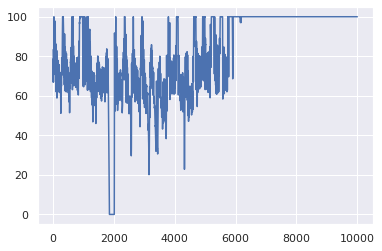

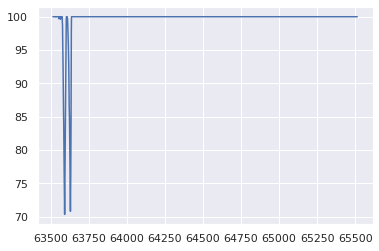

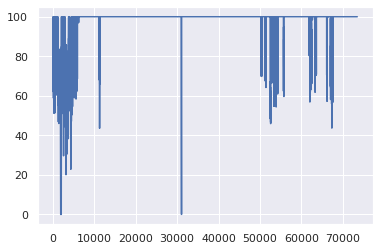

In [ ]:
plt.plot(df[[input2]][0:10000])
plt.savefig('/content/first10000.png')
plt.show()

plt.plot(df[[input2]][-10000:-8000])
plt.savefig('/content/last10000.png')
plt.show()

plt.plot(df[[input2]][:])
plt.savefig('/content/all.png')
plt.show()

## LSTM

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes).to('cuda')

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size).to('cuda')
        
        out = self.fc(h_out)
        return out

In [ ]:
param_lstm = {
    'num_epochs':1200,
    'batch_num':1,
    'learning_rate': 0.008,
    'dropout': 0,
    'input_size': len(input_list),
    'hidden_size': 7,
    'num_layers': 1,
    'num_classes': 24, # should be same as pred_length
    'seq_length': 48,
    'pred_length':24,
    'train_size': 55000,
    'validation_size': 5000,
    'test_size': 10000,
}

sc = MinMaxScaler()
training_data = sc.fit_transform(df_input)
x, y = sliding_windows(training_data, param_lstm['seq_length'], param_lstm['pred_length'], sc)
dataX, dataY, trainX, trainY, validationX, validationY, testX, testY = train_test_split(x, y, param_lstm)

fields = ['index'] + list(param_lstm.keys()) + [ 'optimizer', 'validation loss', 'test_mae_loss', 'test_mape_loss']

results_path = r'/content/drive/MyDrive/APS490/ML/model6_results_lstm/'
if not os.path.exists(results_path):
  os.mkdir(results_path)
os.chdir(results_path)
for f in os.listdir():
  if os.path.isdir(f):
    shutil.rmtree(f)
  else:
    os.remove(f)


results = []
for criteria in ['huber_0.005', 'huber_0.01', 'huber_0.015', 'huber_0.02', 'huber_0.025','huber_0.03']:
  os.chdir(results_path)
  min_loss, index = -1, -1
  predict_df, true_df, model_to_save = None, None, None
  rows = []
  param_lstm['criterion'] = criteria

  count = 0
  for sq in [48]:
    param_lstm['seq_length'] = sq
    for hidden_size in [4]:
      param_lstm['hidden_size'] = hidden_size
      
      test_predict_df, test_true_df, test_predict_np, test_true_np, validation_loss, test_mae_loss, test_mape_loss, model = execute_and_save(param_lstm, 'lstm', trainX, trainY, validationX, validationY, testX, testY)
      print('val_loss:', validation_loss)
      print('mae:', test_mae_loss)
      print('mape:', test_mape_loss)
      row = list(param_lstm.values())
      rows.append([count] + row + [validation_loss, test_mae_loss, test_mape_loss])
      if min_loss < 0 or min_loss > validation_loss:
        min_loss = validation_loss
        index = count
        predict_df, true_df, model_to_save = test_predict_df, test_true_df, model
      count += 1


  filename = "{}_results_report.csv".format(criteria)
  # writing to csv file 
  with open(filename, 'w') as csvfile: 
      csvwriter = csv.writer(csvfile) 
      csvwriter.writerow(fields) 
      csvwriter.writerows(rows)
  os.mkdir(results_path+"{}_optimized_model".format(criteria))
  os.chdir(results_path+"{}_optimized_model".format(criteria))
  predict_df.to_csv('prediction_tesetY_results_{}(index:{}).csv'.format(criteria, index))
  true_df.to_csv('true_testY_results_{}(index:{}).csv'.format(criteria, index))
  torch.save(model_to_save, 'model_{}(index:{}).pth'.format(criteria, index))
  results.append(rows[index])

os.chdir(results_path)
filename = "report.csv"
with open(filename, 'w') as f: 
  csvwriter = csv.writer(f) 
  csvwriter.writerow(fields) 
  csvwriter.writerows(results)

val: 13343 inval_count 40


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00063, val_loss: 0.00061
Epoch: 99, train_loss: 0.00015, val_loss: 0.00015
Epoch: 149, train_loss: 0.00014, val_loss: 0.00014
Epoch: 199, train_loss: 0.00013, val_loss: 0.00013
Epoch: 249, train_loss: 0.00012, val_loss: 0.00012
Epoch: 299, train_loss: 0.00009, val_loss: 0.00008
Epoch: 349, train_loss: 0.00007, val_loss: 0.00007
Epoch: 399, train_loss: 0.00006, val_loss: 0.00006
Epoch: 449, train_loss: 0.00006, val_loss: 0.00006
Epoch: 499, train_loss: 0.00006, val_loss: 0.00006
Epoch: 549, train_loss: 0.00006, val_loss: 0.00006
Epoch: 599, train_loss: 0.00006, val_loss: 0.00006
Epoch: 649, train_loss: 0.00006, val_loss: 0.00006
Epoch: 699, train_loss: 0.00006, val_loss: 0.00006
Epoch: 749, train_loss: 0.00006, val_loss: 0.00006
Epoch: 799, train_loss: 0.00006, val_loss: 0.00006
Epoch: 849, train_loss: 0.00006, val_loss: 0.00006
Epoch: 899, train_loss: 0.00006, val_loss: 0.00006
Epoch: 949, train_loss: 0.00006, val_loss: 0.00006
Epoch: 999, train_loss: 0.00006, 

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00100, val_loss: 0.00099
Epoch: 99, train_loss: 0.00032, val_loss: 0.00033
Epoch: 149, train_loss: 0.00029, val_loss: 0.00030
Epoch: 199, train_loss: 0.00025, val_loss: 0.00025
Epoch: 249, train_loss: 0.00019, val_loss: 0.00019
Epoch: 299, train_loss: 0.00014, val_loss: 0.00014
Epoch: 349, train_loss: 0.00013, val_loss: 0.00013
Epoch: 399, train_loss: 0.00012, val_loss: 0.00012
Epoch: 449, train_loss: 0.00012, val_loss: 0.00012
Epoch: 499, train_loss: 0.00014, val_loss: 0.00014
Epoch: 549, train_loss: 0.00011, val_loss: 0.00011
Epoch: 599, train_loss: 0.00011, val_loss: 0.00011
Epoch: 649, train_loss: 0.00011, val_loss: 0.00011
Epoch: 699, train_loss: 0.00011, val_loss: 0.00011
Epoch: 749, train_loss: 0.00011, val_loss: 0.00011
Epoch: 799, train_loss: 0.00014, val_loss: 0.00013
Epoch: 849, train_loss: 0.00011, val_loss: 0.00011
Epoch: 899, train_loss: 0.00012, val_loss: 0.00011
Epoch: 949, train_loss: 0.00011, val_loss: 0.00011
Epoch: 999, train_loss: 0.00012, 

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00104, val_loss: 0.00099
Epoch: 99, train_loss: 0.00044, val_loss: 0.00045
Epoch: 149, train_loss: 0.00027, val_loss: 0.00027
Epoch: 199, train_loss: 0.00021, val_loss: 0.00021
Epoch: 249, train_loss: 0.00019, val_loss: 0.00019
Epoch: 299, train_loss: 0.00018, val_loss: 0.00018
Epoch: 349, train_loss: 0.00018, val_loss: 0.00018
Epoch: 399, train_loss: 0.00017, val_loss: 0.00017
Epoch: 449, train_loss: 0.00017, val_loss: 0.00017
Epoch: 499, train_loss: 0.00017, val_loss: 0.00017
Epoch: 549, train_loss: 0.00017, val_loss: 0.00017
Epoch: 599, train_loss: 0.00017, val_loss: 0.00016
Epoch: 649, train_loss: 0.00016, val_loss: 0.00016
Epoch: 699, train_loss: 0.00016, val_loss: 0.00016
Epoch: 749, train_loss: 0.00016, val_loss: 0.00016
Epoch: 799, train_loss: 0.00016, val_loss: 0.00016
Epoch: 849, train_loss: 0.00016, val_loss: 0.00016
Epoch: 899, train_loss: 0.00016, val_loss: 0.00016
Epoch: 949, train_loss: 0.00016, val_loss: 0.00016
Epoch: 999, train_loss: 0.00016, 

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00137, val_loss: 0.00133
Epoch: 99, train_loss: 0.00056, val_loss: 0.00058
Epoch: 149, train_loss: 0.00040, val_loss: 0.00040
Epoch: 199, train_loss: 0.00031, val_loss: 0.00031
Epoch: 249, train_loss: 0.00027, val_loss: 0.00027
Epoch: 299, train_loss: 0.00025, val_loss: 0.00025
Epoch: 349, train_loss: 0.00024, val_loss: 0.00023
Epoch: 399, train_loss: 0.00023, val_loss: 0.00022
Epoch: 449, train_loss: 0.00022, val_loss: 0.00022
Epoch: 499, train_loss: 0.00022, val_loss: 0.00021
Epoch: 549, train_loss: 0.00021, val_loss: 0.00021
Epoch: 599, train_loss: 0.00021, val_loss: 0.00020
Epoch: 649, train_loss: 0.00021, val_loss: 0.00020
Epoch: 699, train_loss: 0.00021, val_loss: 0.00020
Epoch: 749, train_loss: 0.00021, val_loss: 0.00020
Epoch: 799, train_loss: 0.00021, val_loss: 0.00020
Epoch: 849, train_loss: 0.00021, val_loss: 0.00020
Epoch: 899, train_loss: 0.00020, val_loss: 0.00020
Epoch: 949, train_loss: 0.00020, val_loss: 0.00020
Epoch: 999, train_loss: 0.00020, 

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00164, val_loss: 0.00167
Epoch: 99, train_loss: 0.00074, val_loss: 0.00075
Epoch: 149, train_loss: 0.00070, val_loss: 0.00072
Epoch: 199, train_loss: 0.00067, val_loss: 0.00068
Epoch: 249, train_loss: 0.00063, val_loss: 0.00064
Epoch: 299, train_loss: 0.00054, val_loss: 0.00055
Epoch: 349, train_loss: 0.00037, val_loss: 0.00037
Epoch: 399, train_loss: 0.00033, val_loss: 0.00033
Epoch: 449, train_loss: 0.00032, val_loss: 0.00032
Epoch: 499, train_loss: 0.00030, val_loss: 0.00030
Epoch: 549, train_loss: 0.00029, val_loss: 0.00029
Epoch: 599, train_loss: 0.00028, val_loss: 0.00028
Epoch: 649, train_loss: 0.00028, val_loss: 0.00027
Epoch: 699, train_loss: 0.00027, val_loss: 0.00027
Epoch: 749, train_loss: 0.00027, val_loss: 0.00026
Epoch: 799, train_loss: 0.00026, val_loss: 0.00026
Epoch: 849, train_loss: 0.00026, val_loss: 0.00026
Epoch: 899, train_loss: 0.00026, val_loss: 0.00025
Epoch: 949, train_loss: 0.00026, val_loss: 0.00025
Epoch: 999, train_loss: 0.00026, 

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00272, val_loss: 0.00266
Epoch: 99, train_loss: 0.00085, val_loss: 0.00087
Epoch: 149, train_loss: 0.00056, val_loss: 0.00057
Epoch: 199, train_loss: 0.00045, val_loss: 0.00045
Epoch: 249, train_loss: 0.00038, val_loss: 0.00038
Epoch: 299, train_loss: 0.00035, val_loss: 0.00035
Epoch: 349, train_loss: 0.00033, val_loss: 0.00033
Epoch: 399, train_loss: 0.00032, val_loss: 0.00032
Epoch: 449, train_loss: 0.00031, val_loss: 0.00031
Epoch: 499, train_loss: 0.00031, val_loss: 0.00031
Epoch: 549, train_loss: 0.00031, val_loss: 0.00030
Epoch: 599, train_loss: 0.00030, val_loss: 0.00030
Epoch: 649, train_loss: 0.00030, val_loss: 0.00030
Epoch: 699, train_loss: 0.00030, val_loss: 0.00029
Epoch: 749, train_loss: 0.00030, val_loss: 0.00029
Epoch: 799, train_loss: 0.00029, val_loss: 0.00028
Epoch: 849, train_loss: 0.00029, val_loss: 0.00028
Epoch: 899, train_loss: 0.00029, val_loss: 0.00028
Epoch: 949, train_loss: 0.00029, val_loss: 0.00028
Epoch: 999, train_loss: 0.00029, 

## GRU

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRUNet, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to('cuda')
        
        h_out, _ = self.gru(x, h_0)
        
        h_out = h_out[:, -1, :].to('cuda')
        
        out = self.fc(h_out).to('cuda')
        
        return out

In [ ]:
param_gru = {
    'num_epochs':1000,
    'batch_num': 1,
    'learning_rate': 0.008,
    'input_size': len(input_list),
    'hidden_size': 7,
    'num_layers': 1,
    'num_classes': 24, # dummy variable, same as pred_length
    'seq_length': 48,
    'pred_length':24,
    'train_size': 55000,
    'test_size': 5000,
    'validation_size': 10000,
    'criterion': 'mae'
}

sc = MinMaxScaler()
training_data = sc.fit_transform(df_input)
x, y = sliding_windows(training_data, param_gru['seq_length'], param_gru['pred_length'], sc)
dataX, dataY, trainX, trainY, validationX, validationY, testX, testY = train_test_split(x, y, param_gru)

fields = ['index'] + list(param_gru.keys()) + ['criterion', 'optimizer', 'validation loss', 'test_mae_loss', 'test_mape_loss']

results_path = r'/content/drive/MyDrive/APS490/ML/model6_results_gru/'
if not os.path.exists(results_path):
  os.mkdir(results_path)
os.chdir(results_path)
for f in os.listdir():
  if os.path.isdir(f):
    shutil.rmtree(f)
  else:
    os.remove(f)


results = []
for criteria in ['huber_0.01', 'huber_0.02', 'huber_0.022', 'huber_0.024','huber_0.025','huber_0.026','huber_0.027','huber_0.028', 'huber_0.03']:
  os.chdir(results_path)
  min_loss, index = -1, -1
  predict_df, true_df, model_to_save = None, None, None
  rows = []
  param_gru['criterion'] = criteria

  count = 0
  for sq in [48]:
    param_gru['seq_length'] = sq
    for hidden_size in [4]:
      param_gru['hidden_size'] = hidden_size
      
      test_predict_df, test_true_df, test_predict_np, test_true_np, validation_loss, test_mae_loss, test_mape_loss, model = execute_and_save(param_gru, 'gru', trainX, trainY, validationX, validationY, testX, testY)
      print('val_loss:', validation_loss)
      print('mae:', test_mae_loss)
      print('mape:', test_mape_loss)
      row = list(param_gru.values())
      rows.append([count] + row + [validation_loss, test_mae_loss, test_mape_loss])
      if min_loss < 0 or min_loss > validation_loss:
        min_loss = validation_loss
        index = count
        predict_df, true_df, model_to_save = test_predict_df, test_true_df, model
      count += 1


  filename = "{}_results_report.csv".format(criteria)
  # writing to csv file 
  with open(filename, 'w') as csvfile: 
      csvwriter = csv.writer(csvfile) 
      csvwriter.writerow(fields) 
      csvwriter.writerows(rows)
  os.mkdir(results_path+"{}_optimized_model".format(criteria))
  os.chdir(results_path+"{}_optimized_model".format(criteria))
  predict_df.to_csv('prediction_tesetY_results_{}(index:{}).csv'.format(criteria, index))
  true_df.to_csv('true_testY_results_{}(index:{}).csv'.format(criteria, index))
  torch.save(model_to_save, 'model_{}(index:{}).pth'.format(criteria, index))
  results.append(rows[index])

os.chdir(results_path)
filename = "report.csv"
with open(filename, 'w') as f: 
  csvwriter = csv.writer(f) 
  csvwriter.writerow(fields) 
  csvwriter.writerows(results)



val: 8349 inval_count 34


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00066, val_loss: 0.00062
Epoch: 99, train_loss: 0.00027, val_loss: 0.00029
Epoch: 149, train_loss: 0.00023, val_loss: 0.00025
Epoch: 199, train_loss: 0.00019, val_loss: 0.00019
Epoch: 249, train_loss: 0.00016, val_loss: 0.00017
Epoch: 299, train_loss: 0.00015, val_loss: 0.00016
Epoch: 349, train_loss: 0.00016, val_loss: 0.00016
Epoch: 399, train_loss: 0.00014, val_loss: 0.00015
Epoch: 449, train_loss: 0.00014, val_loss: 0.00015
Epoch: 499, train_loss: 0.00013, val_loss: 0.00014
Epoch: 549, train_loss: 0.00013, val_loss: 0.00014
Epoch: 599, train_loss: 0.00013, val_loss: 0.00013
Epoch: 649, train_loss: 0.00012, val_loss: 0.00013
Epoch: 699, train_loss: 0.00012, val_loss: 0.00013
Epoch: 749, train_loss: 0.00012, val_loss: 0.00012
Epoch: 799, train_loss: 0.00012, val_loss: 0.00012
Epoch: 849, train_loss: 0.00011, val_loss: 0.00012
Epoch: 899, train_loss: 0.00011, val_loss: 0.00012
Epoch: 949, train_loss: 0.00011, val_loss: 0.00012
Epoch: 999, train_loss: 0.00011, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00168, val_loss: 0.00159
Epoch: 99, train_loss: 0.00054, val_loss: 0.00058
Epoch: 149, train_loss: 0.00050, val_loss: 0.00053
Epoch: 199, train_loss: 0.00042, val_loss: 0.00046
Epoch: 249, train_loss: 0.00031, val_loss: 0.00033
Epoch: 299, train_loss: 0.00027, val_loss: 0.00029
Epoch: 349, train_loss: 0.00025, val_loss: 0.00027
Epoch: 399, train_loss: 0.00024, val_loss: 0.00025
Epoch: 449, train_loss: 0.00023, val_loss: 0.00024
Epoch: 499, train_loss: 0.00022, val_loss: 0.00024
Epoch: 549, train_loss: 0.00022, val_loss: 0.00023
Epoch: 599, train_loss: 0.00022, val_loss: 0.00023
Epoch: 649, train_loss: 0.00022, val_loss: 0.00023
Epoch: 699, train_loss: 0.00021, val_loss: 0.00022
Epoch: 749, train_loss: 0.00022, val_loss: 0.00023
Epoch: 799, train_loss: 0.00021, val_loss: 0.00022
Epoch: 849, train_loss: 0.00021, val_loss: 0.00022
Epoch: 899, train_loss: 0.00021, val_loss: 0.00022
Epoch: 949, train_loss: 0.00021, val_loss: 0.00022
Epoch: 999, train_loss: 0.00021, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00144, val_loss: 0.00129
Epoch: 99, train_loss: 0.00054, val_loss: 0.00058
Epoch: 149, train_loss: 0.00048, val_loss: 0.00051
Epoch: 199, train_loss: 0.00039, val_loss: 0.00041
Epoch: 249, train_loss: 0.00029, val_loss: 0.00031
Epoch: 299, train_loss: 0.00027, val_loss: 0.00029
Epoch: 349, train_loss: 0.00026, val_loss: 0.00027
Epoch: 399, train_loss: 0.00025, val_loss: 0.00026
Epoch: 449, train_loss: 0.00023, val_loss: 0.00025
Epoch: 499, train_loss: 0.00026, val_loss: 0.00024
Epoch: 549, train_loss: 0.00022, val_loss: 0.00023
Epoch: 599, train_loss: 0.00022, val_loss: 0.00023
Epoch: 649, train_loss: 0.00022, val_loss: 0.00023
Epoch: 699, train_loss: 0.00021, val_loss: 0.00022
Epoch: 749, train_loss: 0.00021, val_loss: 0.00022
Epoch: 799, train_loss: 0.00022, val_loss: 0.00023
Epoch: 849, train_loss: 0.00021, val_loss: 0.00022
Epoch: 899, train_loss: 0.00021, val_loss: 0.00022
Epoch: 949, train_loss: 0.00021, val_loss: 0.00022
Epoch: 999, train_loss: 0.00021, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00112, val_loss: 0.00112
Epoch: 99, train_loss: 0.00066, val_loss: 0.00071
Epoch: 149, train_loss: 0.00062, val_loss: 0.00066
Epoch: 199, train_loss: 0.00055, val_loss: 0.00060
Epoch: 249, train_loss: 0.00046, val_loss: 0.00049
Epoch: 299, train_loss: 0.00039, val_loss: 0.00042
Epoch: 349, train_loss: 0.00034, val_loss: 0.00036
Epoch: 399, train_loss: 0.00032, val_loss: 0.00035
Epoch: 449, train_loss: 0.00030, val_loss: 0.00031
Epoch: 499, train_loss: 0.00028, val_loss: 0.00030
Epoch: 549, train_loss: 0.00027, val_loss: 0.00028
Epoch: 599, train_loss: 0.00026, val_loss: 0.00027
Epoch: 649, train_loss: 0.00025, val_loss: 0.00026
Epoch: 699, train_loss: 0.00024, val_loss: 0.00026
Epoch: 749, train_loss: 0.00024, val_loss: 0.00025
Epoch: 799, train_loss: 0.00024, val_loss: 0.00025
Epoch: 849, train_loss: 0.00024, val_loss: 0.00025
Epoch: 899, train_loss: 0.00024, val_loss: 0.00025
Epoch: 949, train_loss: 0.00023, val_loss: 0.00024
Epoch: 999, train_loss: 0.00023, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00125, val_loss: 0.00116
Epoch: 99, train_loss: 0.00064, val_loss: 0.00069
Epoch: 149, train_loss: 0.00059, val_loss: 0.00063
Epoch: 199, train_loss: 0.00050, val_loss: 0.00054
Epoch: 249, train_loss: 0.00042, val_loss: 0.00044
Epoch: 299, train_loss: 0.00036, val_loss: 0.00038
Epoch: 349, train_loss: 0.00033, val_loss: 0.00034
Epoch: 399, train_loss: 0.00031, val_loss: 0.00032
Epoch: 449, train_loss: 0.00029, val_loss: 0.00031
Epoch: 499, train_loss: 0.00028, val_loss: 0.00030
Epoch: 549, train_loss: 0.00027, val_loss: 0.00028
Epoch: 599, train_loss: 0.00026, val_loss: 0.00027
Epoch: 649, train_loss: 0.00025, val_loss: 0.00026
Epoch: 699, train_loss: 0.00027, val_loss: 0.00029
Epoch: 749, train_loss: 0.00025, val_loss: 0.00026
Epoch: 799, train_loss: 0.00025, val_loss: 0.00026
Epoch: 849, train_loss: 0.00024, val_loss: 0.00025
Epoch: 899, train_loss: 0.00024, val_loss: 0.00025
Epoch: 949, train_loss: 0.00024, val_loss: 0.00025
Epoch: 999, train_loss: 0.00024, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00275, val_loss: 0.00258
Epoch: 99, train_loss: 0.00064, val_loss: 0.00068
Epoch: 149, train_loss: 0.00056, val_loss: 0.00060
Epoch: 199, train_loss: 0.00043, val_loss: 0.00045
Epoch: 249, train_loss: 0.00038, val_loss: 0.00040
Epoch: 299, train_loss: 0.00037, val_loss: 0.00039
Epoch: 349, train_loss: 0.00032, val_loss: 0.00034
Epoch: 399, train_loss: 0.00030, val_loss: 0.00032
Epoch: 449, train_loss: 0.00029, val_loss: 0.00030
Epoch: 499, train_loss: 0.00027, val_loss: 0.00029
Epoch: 549, train_loss: 0.00027, val_loss: 0.00028
Epoch: 599, train_loss: 0.00026, val_loss: 0.00027
Epoch: 649, train_loss: 0.00026, val_loss: 0.00027
Epoch: 699, train_loss: 0.00026, val_loss: 0.00027
Epoch: 749, train_loss: 0.00025, val_loss: 0.00027
Epoch: 799, train_loss: 0.00025, val_loss: 0.00026
Epoch: 849, train_loss: 0.00025, val_loss: 0.00026
Epoch: 899, train_loss: 0.00025, val_loss: 0.00026
Epoch: 949, train_loss: 0.00025, val_loss: 0.00026
Epoch: 999, train_loss: 0.00025, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00167, val_loss: 0.00164
Epoch: 99, train_loss: 0.00070, val_loss: 0.00075
Epoch: 149, train_loss: 0.00064, val_loss: 0.00068
Epoch: 199, train_loss: 0.00053, val_loss: 0.00056
Epoch: 249, train_loss: 0.00039, val_loss: 0.00041
Epoch: 299, train_loss: 0.00036, val_loss: 0.00039
Epoch: 349, train_loss: 0.00035, val_loss: 0.00037
Epoch: 399, train_loss: 0.00034, val_loss: 0.00035
Epoch: 449, train_loss: 0.00032, val_loss: 0.00034
Epoch: 499, train_loss: 0.00031, val_loss: 0.00033
Epoch: 549, train_loss: 0.00031, val_loss: 0.00032
Epoch: 599, train_loss: 0.00030, val_loss: 0.00032
Epoch: 649, train_loss: 0.00029, val_loss: 0.00030
Epoch: 699, train_loss: 0.00028, val_loss: 0.00030
Epoch: 749, train_loss: 0.00028, val_loss: 0.00029
Epoch: 799, train_loss: 0.00027, val_loss: 0.00029
Epoch: 849, train_loss: 0.00027, val_loss: 0.00028
Epoch: 899, train_loss: 0.00027, val_loss: 0.00028
Epoch: 949, train_loss: 0.00027, val_loss: 0.00028
Epoch: 999, train_loss: 0.00027, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00183, val_loss: 0.00186
Epoch: 99, train_loss: 0.00073, val_loss: 0.00078
Epoch: 149, train_loss: 0.00064, val_loss: 0.00068
Epoch: 199, train_loss: 0.00053, val_loss: 0.00057
Epoch: 249, train_loss: 0.00041, val_loss: 0.00045
Epoch: 299, train_loss: 0.00038, val_loss: 0.00041
Epoch: 349, train_loss: 0.00036, val_loss: 0.00039
Epoch: 399, train_loss: 0.00034, val_loss: 0.00036
Epoch: 449, train_loss: 0.00033, val_loss: 0.00035
Epoch: 499, train_loss: 0.00032, val_loss: 0.00033
Epoch: 549, train_loss: 0.00030, val_loss: 0.00032
Epoch: 599, train_loss: 0.00030, val_loss: 0.00031
Epoch: 649, train_loss: 0.00029, val_loss: 0.00031
Epoch: 699, train_loss: 0.00029, val_loss: 0.00030
Epoch: 749, train_loss: 0.00029, val_loss: 0.00030
Epoch: 799, train_loss: 0.00028, val_loss: 0.00030
Epoch: 849, train_loss: 0.00028, val_loss: 0.00030
Epoch: 899, train_loss: 0.00030, val_loss: 0.00032
Epoch: 949, train_loss: 0.00028, val_loss: 0.00029
Epoch: 999, train_loss: 0.00028, 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.00145, val_loss: 0.00150
Epoch: 99, train_loss: 0.00085, val_loss: 0.00091
Epoch: 149, train_loss: 0.00079, val_loss: 0.00085
Epoch: 199, train_loss: 0.00074, val_loss: 0.00080
Epoch: 249, train_loss: 0.00062, val_loss: 0.00066
Epoch: 299, train_loss: 0.00051, val_loss: 0.00055
Epoch: 349, train_loss: 0.00044, val_loss: 0.00046
Epoch: 399, train_loss: 0.00039, val_loss: 0.00042
Epoch: 449, train_loss: 0.00036, val_loss: 0.00038
Epoch: 499, train_loss: 0.00034, val_loss: 0.00036
Epoch: 549, train_loss: 0.00033, val_loss: 0.00035
Epoch: 599, train_loss: 0.00033, val_loss: 0.00035
Epoch: 649, train_loss: 0.00031, val_loss: 0.00033
Epoch: 699, train_loss: 0.00031, val_loss: 0.00033
Epoch: 749, train_loss: 0.00031, val_loss: 0.00033
Epoch: 799, train_loss: 0.00031, val_loss: 0.00032
Epoch: 849, train_loss: 0.00030, val_loss: 0.00032
Epoch: 899, train_loss: 0.00030, val_loss: 0.00032
Epoch: 949, train_loss: 0.00030, val_loss: 0.00032
Epoch: 999, train_loss: 0.00030, 

## Baseline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
def format_names(name):
  temp = name.split(' > ')[-1]
  temp = temp.replace('.', ' ')
  return temp
df_input.columns = [format_names(col) for col in df_input.columns]
for col in df_input.columns:
  adf_test(df_input[col])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Augmented Dickey-Fuller Test: 
ADF test statistic     -7.157383e+00
p-value                 3.029832e-10
# lags used             3.600000e+01
# observations          7.341800e+04
critical value (1%)    -3.430439e+00
critical value (5%)    -2.861579e+00
critical value (10%)   -2.566791e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -1.167170e+01
p-value                 1.828289e-21
# lags used             6.300000e+01
# observations          7.339100e+04
critical value (1%)    -3.430439e+00
critical value (5%)    -2.861579e+00
critical value (10%)   -2.566791e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -1.007095e+01
p-value                 1.259427e-17
# lags used             5.000000e+01
# observations          7.340400e+04
critical value (1%)

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_input)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Temp (°C) ::  8138.77   > 60.0627   =>   True
Fin Tube Radiation Valve Position ::  1847.02   > 40.1749   =>   True
Zone Air Temperature ::  521.72    > 24.2761   =>   True
Primary Air Air Flow ::  22.11     > 12.3212   =>   True
Primary Air Air Flow Setpoint ::  0.0       > 4.1296    =>   False


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


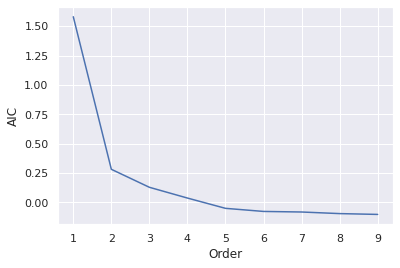

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 13, Jan, 2022
Time:                     18:05:00
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                 -0.0552338
Nobs:                     63449.0    HQIC:                -0.0705060
Log likelihood:          -447542.    FPE:                   0.925555
AIC:                   -0.0773616    Det(Omega_mle):        0.923297
--------------------------------------------------------------------
Results for equation Temp (°C)
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                        0.017255         0.088148            0.196           0.845
L1.Temp (°C)                                 0.999180         0.0039

In [ ]:
sc = MinMaxScaler()
# data = sc.fit_transform(df_input)
data=df_input
data = pd.DataFrame(data, columns=df_input.columns)
train = data.iloc[:-10000,:]
test = data.iloc[-10000:,:]
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

results = forecasting_model.fit(6)
results.summary()

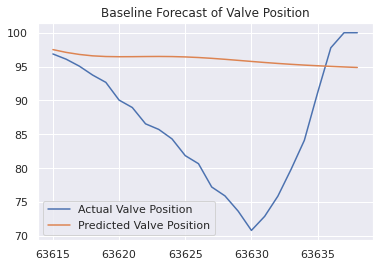

In [ ]:
sample_index = 100
lagged_values = test[:sample_index].values[-6:]
next = results.forecast(y= lagged_values, steps=24)
next = pd.DataFrame(next, columns=df_input.columns)
actual_air_flow = test[sample_index:sample_index+24]['Fin Tube Radiation Valve Position']
predicted = next['Fin Tube Radiation Valve Position']
predicted.index = actual_air_flow.index
plt.plot(actual_air_flow, label='Actual Valve Position')
plt.plot(predicted, label='Predicted Valve Position')
plt.legend()
plt.title('Baseline Forecast of Valve Position')
final = pd.DataFrame()
final['Actual Valve Position'] = actual_air_flow 
final['Predicted Valve Position'] = predicted 
path = r'/content/drive/MyDrive/APS490/ML/new_baseline_results_model6.csv'
final.to_csv(path)

In [ ]:
print(lagged_values)

[[  0.6        100.          20.84609985 180.5149078  180.        ]
 [  0.6         99.82865906  20.82401276 157.9107361  144.        ]
 [  0.6         99.66397095  20.80966568 141.1892548  144.        ]
 [  0.6         99.02329254  20.79361916 142.9514465  144.        ]
 [  0.6         98.61875916  20.79180336 140.0140686  144.        ]
 [  0.6         98.04771423  20.79435349 143.4780273  144.        ]]


TEST MAE OF BASELINE:  1.3231686649938357
TEST MAPE OF BASELINE (Percent):  1.5000700015324469


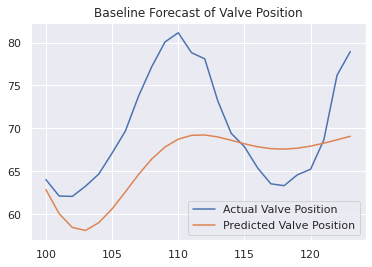

In [ ]:
sample_index = 100
lagged_values = train[:sample_index].values[-6:]
next = results.forecast(y= lagged_values, steps=24)
next = pd.DataFrame(next, columns=df_input.columns)
actual_air_flow = train[sample_index:sample_index+24]['Fin Tube Radiation Valve Position']
predicted = next['Fin Tube Radiation Valve Position']
predicted.index = actual_air_flow.index
plt.plot(actual_air_flow, label='Actual Valve Position')
plt.plot(predicted, label='Predicted Valve Position')
plt.legend()
plt.title('Baseline Forecast of Valve Position')
final = pd.DataFrame()
final['Actual Valve Position'] = actual_air_flow 
final['Predicted Valve Position'] = predicted 
path = r'/content/drive/MyDrive/APS490/ML/baseline_results_model6.csv'
final.to_csv(path)

mae_list = []
mape_list = []
for i in np.arange(start=6,step=24,stop=len(test)-24):
  lagged_values = test[:i].values[-6:]
  next = (results.forecast(y= lagged_values, steps=24))
  next = pd.DataFrame(next, columns=df_input.columns)
  actual = test[i:i+24]['Fin Tube Radiation Valve Position']
  forecasted = np.array(next['Fin Tube Radiation Valve Position'])
  actual = np.array(actual)
  mae = np.mean(np.abs(forecasted - actual))
  mape = np.mean(np.abs((forecasted- actual) / actual))
  mae_list.append(mae)
  if mape< 10:
    mape_list.append(mape)
print('TEST MAE OF BASELINE: ', np.mean(mae_list))
print('TEST MAPE OF BASELINE (Percent): ', np.mean(mape_list)*100)

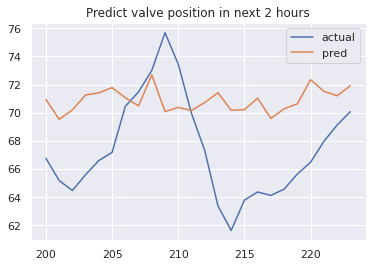

In [ ]:
index = 200
sc = MinMaxScaler()
sc = sc.fit(df_input)
sampleX = sc.transform(train[index-48:index]).reshape(1,48, 5)
sampleX = torch.tensor(sampleX).to('cuda')
sampleX = sampleX.float()
lstm_model = torch.load('/content/drive/MyDrive/APS490/ML/model6_results_lstm/huber_0.015_optimized_model/model_huber_0.015(index:0).pth')
lstm_model.eval()
lstm_model.to('cuda')

pred = lstm_model(sampleX)
min = sc.data_min_[1]
max = sc.data_max_[1]

pred = pred * (max - min) + min
pred = pred.cpu()
pred = pred.detach().numpy()
plt.plot(train[index:index+24]['Fin Tube Radiation Valve Position'], label='actual')

plt.plot([i for i in range(index, index+24)], pred[0], label='pred')
plt.legend()
plt.title('Predict valve position in next 2 hours')
plt.savefig('/content/fig1.png')
plt.show()

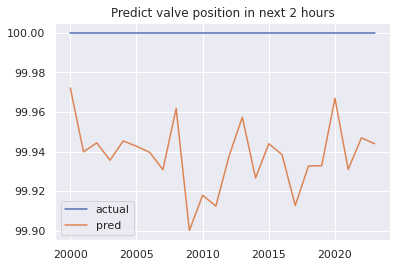

In [ ]:
index = 20000
sc = MinMaxScaler()
sc = sc.fit(df_input)
sampleX = sc.transform(train[index-48:index]).reshape(1,48, 5)
sampleX = torch.tensor(sampleX).to('cuda')
sampleX = sampleX.float()
lstm_model = torch.load('/content/drive/MyDrive/APS490/ML/model6_results_lstm/huber_0.015_optimized_model/model_huber_0.015(index:0).pth')
lstm_model.eval()
lstm_model.to('cuda')

pred = lstm_model(sampleX)
min = sc.data_min_[1]
max = sc.data_max_[1]

pred = pred * (max - min) + min
pred = pred.cpu()
pred = pred.detach().numpy()
plt.plot(train[index:index+24]['Fin Tube Radiation Valve Position'], label='actual')

plt.plot([i for i in range(index, index+24)], pred[0], label='pred')
plt.legend()
plt.title('Predict valve position in next 2 hours')
plt.savefig('/content/fig2.png')
plt.show()

# Result